In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
track_features = pd.read_csv("/content/data/track_features/tf_mini.csv")


Text(0.5, 1.0, 'Distribution of Track Keys')

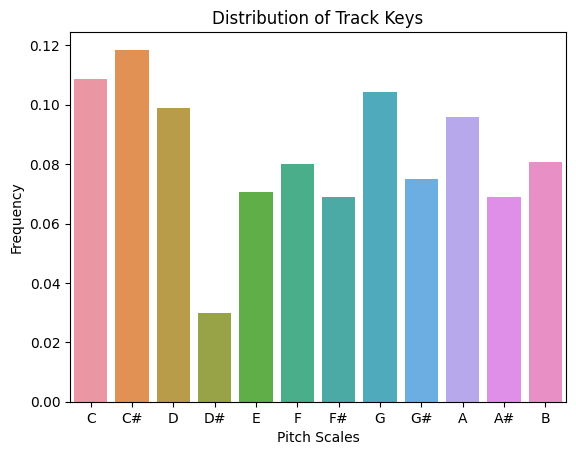

In [5]:
keys = track_features.key.value_counts().sort_index()
x_axis=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
sns.barplot(x=x_axis, y=keys.values / keys.sum())
plt.xlabel('Pitch Scales')
plt.ylabel('Frequency')
plt.title('Distribution of Track Keys')


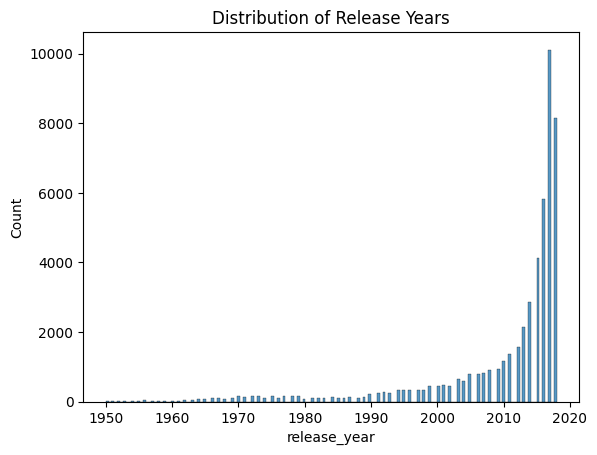

In [6]:
sns.histplot(track_features.release_year)
plt.title("Distribution of Release Years");

In [10]:
df1 = track_features[['beat_strength','bounciness','danceability','dyn_range_mean']]

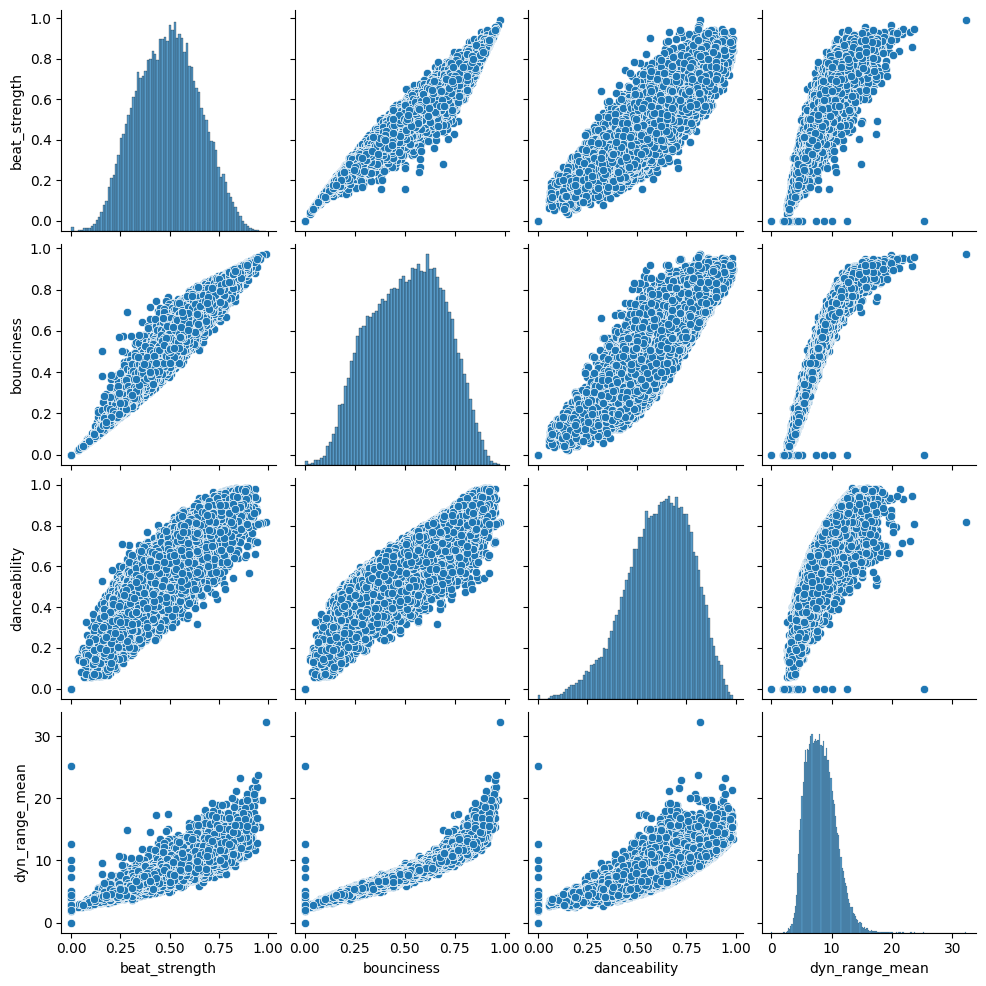

In [11]:
sns.pairplot(df1)

In [12]:
track_features.to_pickle("data/track_features/track_features.pkl")

In [43]:
training_set = pd.read_csv("/content/data/training_set/train_sessions.csv")
training_set.user_hist_start = training_set.hist_user_behavior_reason_start.astype('category')
training_set.user_hist_end = training_set.hist_user_behavior_reason_end.astype('category')
training_set.user_context = training_set.context_type.astype('category')
training_set.date = training_set.date.apply(pd.to_datetime)

training_set['skipped'] = (training_set.skip_1).astype('int32')
training_set = training_set.drop(columns=['skip_1','skip_2','skip_3','not_skipped'])

In [44]:
test_set = pd.read_csv("/content/data/training_set/test_sessions.csv")
test_set.user_hist_start = test_set.hist_user_behavior_reason_start.astype('category')
test_set.user_hist_end = test_set.hist_user_behavior_reason_end.astype('category')
test_set.user_context = test_set.context_type.astype('category')
test_set.date = test_set.date.apply(pd.to_datetime)

test_set['skipped'] = (test_set.skip_1).astype('int32')
test_set = test_set.drop(columns=['skip_1','skip_2','skip_3','not_skipped'])

In [45]:
val_set = pd.read_csv("/content/data/training_set/val_sessions.csv")
val_set.user_hist_start = val_set.hist_user_behavior_reason_start.astype('category')
val_set.user_hist_end = val_set.hist_user_behavior_reason_end.astype('category')
val_set.user_context = val_set.context_type.astype('category')
val_set.date = val_set.date.apply(pd.to_datetime)
val_set['skipped'] = (val_set.skip_1).astype('int32')
val_set_set = val_set.drop(columns=['skip_1','skip_2','skip_3','not_skipped'])

In [16]:
track_data = pd.read_pickle("data/track_features/track_features.pkl")

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

track_data['track_id'] = label_encoder.fit_transform(track_data['track_id'])
track_data['mode'] = label_encoder.fit_transform(track_features['mode'])
training_set['session_id'] = label_encoder.fit_transform(training_set['session_id'])
training_set['context_type'] = label_encoder.fit_transform(training_set['context_type'])
training_set['hist_user_behavior_reason_start'] = label_encoder.fit_transform(training_set['hist_user_behavior_reason_start'])
training_set['hist_user_behavior_reason_end'] = label_encoder.fit_transform(training_set['hist_user_behavior_reason_end'])
training_set['track_id_clean'] = label_encoder.fit_transform(training_set['track_id_clean'])


In [18]:
val_set['session_id'] = label_encoder.fit_transform(val_set['session_id'])
val_set['context_type'] = label_encoder.fit_transform(val_set['context_type'])
val_set['hist_user_behavior_reason_start'] = label_encoder.fit_transform(val_set['hist_user_behavior_reason_start'])
val_set['hist_user_behavior_reason_end'] = label_encoder.fit_transform(val_set['hist_user_behavior_reason_end'])
val_set['track_id_clean'] = label_encoder.fit_transform(val_set['track_id_clean'])

In [19]:
test_set['session_id'] = label_encoder.fit_transform(test_set['session_id'])
test_set['context_type'] = label_encoder.fit_transform(test_set['context_type'])
test_set['hist_user_behavior_reason_start'] = label_encoder.fit_transform(test_set['hist_user_behavior_reason_start'])
test_set['hist_user_behavior_reason_end'] = label_encoder.fit_transform(test_set['hist_user_behavior_reason_end'])
test_set['track_id_clean'] = label_encoder.fit_transform(test_set['track_id_clean'])

In [21]:
session_data_train = (training_set[['session_id','session_position','track_id_clean', 'skipped']].merge(
        track_data,
        how='left',
        left_on=['track_id_clean'],
        right_on=['track_id'] ).drop(columns='track_id_clean'))
session_data_train = pd.DataFrame(session_data_train)

In [22]:
session_data_val = (val_set[['session_id','session_position','track_id_clean', 'skipped']].merge(
        track_data,
        how='left',
        left_on=['track_id_clean'],
        right_on=['track_id'] ).drop(columns='track_id_clean'))
session_data_val = pd.DataFrame(session_data_val)

In [23]:
session_data_test = (test_set[['session_id','session_position','track_id_clean', 'skipped']].merge(
        track_data,
        how='left',
        left_on=['track_id_clean'],
        right_on=['track_id'] ).drop(columns='track_id_clean'))
session_data_test = pd.DataFrame(session_data_test)

In [24]:
session_data_train = pd.concat((
    session_data_train,
    session_data_train.drop(columns=['track_id'])\
        .groupby('session_id')\
        .shift(1)\
        .rename(columns={c:f"previous_{c}" for c in session_data_train.columns})
), axis=1)
session_data_train.head()

,session_id,session_position,skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,...,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
0,0,1,1,39489,199.720001,2014.0,99.987144,0.027755,0.371172,0.351335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,1,1078,243.934418,2018.0,99.048279,0.512591,0.390874,0.356513,...,4.0,0.849895,-0.088900,0.512215,0.098063,-0.635531,-0.066308,0.236733,-0.301593,-0.100681
2,0,3,0,22240,295.720001,2018.0,99.682671,0.019842,0.277265,0.250243,...,4.0,0.406391,0.261233,-0.059367,-0.164463,-0.464504,0.420922,0.194879,-0.460330,-0.355668
3,0,4,0,25815,176.186676,2018.0,99.940292,0.104184,0.458526,0.541713,...,4.0,0.317059,-0.138954,0.218722,0.180962,0.081914,0.744147,0.033209,0.291459,-0.235579
4,0,5,0,21438,211.438995,2013.0,99.849396,0.000054,0.238629,0.231219,...,4.0,0.714719,-0.282159,0.332340,0.238804,-0.233448,-0.277285,0.201007,-0.041600,-0.013304


In [25]:
session_data_val = pd.concat((
    session_data_val,
    session_data_val.drop(columns=['track_id'])\
        .groupby('session_id')\
        .shift(1)\
        .rename(columns={c:f"previous_{c}" for c in session_data_val.columns})
), axis=1)
session_data_val.head()

,session_id,session_position,skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,...,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
0,0,1,0,1418,171.013336,2017.0,99.963280,0.040444,0.660850,0.792830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,0,1658,249.679993,2016.0,99.991501,0.094713,0.475131,0.496440,...,4.0,0.809512,-0.883449,0.324988,0.227112,0.119579,-0.290498,-0.023851,-0.483995,0.176056
2,0,3,0,2482,194.880005,2016.0,99.371239,0.067381,0.533194,0.568836,...,4.0,0.183639,-0.657532,0.229902,0.142876,0.050765,-0.324273,-0.004463,-0.408742,0.276671
3,0,4,1,1037,248.893326,2003.0,99.956528,0.060341,0.559503,0.649244,...,4.0,0.363280,-0.836892,0.345439,0.238790,0.030634,-0.271049,0.015354,-0.538008,0.146896
4,0,5,0,1929,131.082443,2017.0,99.802841,0.320900,0.805504,0.842511,...,4.0,0.674938,-0.886654,0.358529,0.240265,0.064898,-0.257393,-0.015741,-0.548913,0.144724


In [26]:
session_data_test = pd.concat((
    session_data_test,
    session_data_test.drop(columns=['track_id'])\
        .groupby('session_id')\
        .shift(1)\
        .rename(columns={c:f"previous_{c}" for c in session_data_test.columns})
), axis=1)
session_data_test.head()

,session_id,session_position,skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,...,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
0,0,1,0,158,185.965714,2015.0,99.957565,0.139790,0.712979,0.779467,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,0,4942,69.121948,2018.0,98.640572,0.000512,0.692282,0.734690,...,4.0,0.177964,-0.835496,0.306872,0.278451,0.081790,-0.263166,0.026212,-0.521610,0.147535
2,0,3,0,8587,312.133331,1985.0,99.947052,0.248621,0.601670,0.605807,...,4.0,0.589202,-0.879898,0.279647,0.168656,0.153511,-0.336406,-0.088119,-0.529407,0.169478
3,0,4,0,1256,207.402496,2018.0,99.976669,0.843155,0.314092,0.333578,...,4.0,0.702495,0.158635,-0.135774,-0.056673,-0.127454,0.704083,0.090253,-0.205655,-0.409986
4,0,5,0,3416,196.133331,2010.0,99.987572,0.012704,0.403655,0.420876,...,4.0,0.184507,-0.214395,0.112881,0.337214,-0.044085,-0.358206,0.115204,-0.039046,0.018446


In [27]:
train_X = session_data_train.drop(columns = ['skipped','session_id','track_id'])
train_y = session_data_train.skipped

In [28]:
val_X = session_data_val.drop(columns = ['skipped','session_id','track_id'])
val_y = session_data_val.skipped

In [29]:
test_X = session_data_test.drop(columns = ['skipped','session_id','track_id'])
test_y = session_data_test.skipped

In [30]:
from lightgbm import LGBMClassifier

In [31]:
lgbm = LGBMClassifier(boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=100,
    objective='binary',
    metric='binary_logloss')

lgbm.fit(train_X, train_y)

print("LGBM Train score: %s" % lgbm.score(train_X,train_y))
print("LGBM Test score:  %s" % lgbm.score(test_X,test_y))
print("LGBM Validation score : %s" % lgbm.score(val_X,val_y))

[LightGBM] [Info] Number of positive: 69390, number of negative: 64681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12977
[LightGBM] [Info] Number of data points in the train set: 134071, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517562 -> initscore=0.070275
[LightGBM] [Info] Start training from score 0.070275
LGBM Train score: 0.7281142081434464
LGBM Test score:  0.7311158543815961
LGBM Validation score : 0.7308623030159948


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves' : [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
    'learning_rate': [0.01,0.02,0.03,0.04,0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200]
 }
lgb = LGBMClassifier(boosting_type='gbdt',objective='binary',metric='binary_logloss')

grid_search = GridSearchCV(estimator=lgb, param_grid=param_grid, cv=3, scoring='accuracy')


grid_search.fit(train_X, train_y)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


test_accuracy = grid_search.best_estimator_.score(test_X, test_y)
print("Test Accuracy:", test_accuracy)

val_accuracy = grid_search.best_estimator_.score(val_X, val_y)
print("Validation Accuracy:", val_accuracy)



[LightGBM] [Info] Number of positive: 46260, number of negative: 43120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12977
[LightGBM] [Info] Number of data points in the train set: 89380, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517565 -> initscore=0.070291
[LightGBM] [Info] Start training from score 0.070291
[LightGBM] [Info] Number of positive: 46260, number of negative: 43121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12976
[LightGBM] [Info] Number of data points in the train set: 89381, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517560 -> initscore=0.070268
[LightGBM] [Info] Start training from score 0.070268
[LightGBM] [In

In [47]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(test_y, lgbm.predict(test_X))
print("AUC Score:", auc_score)

AUC Score: 0.7315146505710288


In [48]:
from sklearn.metrics import recall_score
recall = recall_score(test_y, lgbm.predict(test_X))
print("Recall:", recall)


Recall: 0.7146994092436001


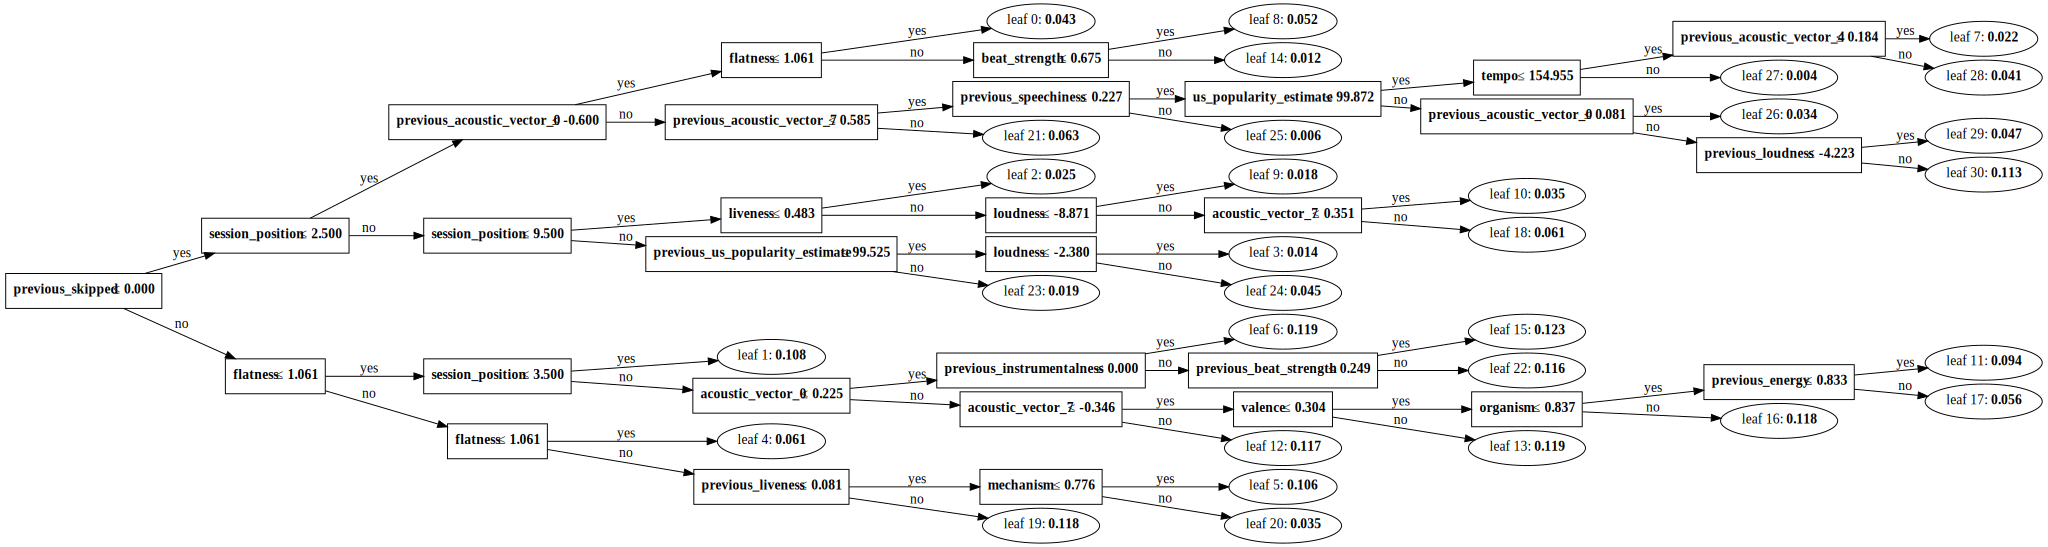

In [49]:

viz = lightgbm.create_tree_digraph(lgbm)
viz